In [2]:
# Data wrangling
import pandas as pd
import numpy as np
# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
# Off FutureWarnings
import warnings 
warnings.filterwarnings('ignore')
#Resampling
from imblearn.over_sampling import SMOTENC 
from sklearn.utils import class_weight
#Dimension Reduction
from sklearn.decomposition import PCA
# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
# Save model
import pickle

In [3]:
## Upload df
df = pd.read_csv('cleaned_data.csv', index_col=0) 
pd.options.mode.chained_assignment = None
df

,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Failure_type
0,Medium,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,NF
1,Low,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,NF
2,Low,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,NF
3,Low,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,NF
4,Low,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Medium,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,NF
9996,High,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,NF
9997,Medium,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,NF
9998,High,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,NF


In [4]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

In [5]:
rename_type = {
    'Low':0,
    'Medium':1,
    'High':2
}
df['Type'].replace(rename_type, inplace = True)

In [18]:
X = df[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df['Failure_type']

Adding a column containg random numeric features and random categorical features

In [7]:
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [44]:
train_accuracies = []
test_accuracies = []

In [45]:

from sklearn.ensemble import RandomForestClassifier
for md in range(1,20):
    rf = RandomForestClassifier(
            n_estimators=100,
            n_jobs=-1,
            min_samples_leaf = 1,
            oob_score=True,
            max_depth=md,
            random_state = 42)
    rf.fit(X_train, y_train)
#     print("Max Depth:", md)
    
    train_accuracies.append(rf.score(X_train, y_train))
    test_accuracies.append(rf.score(X_test, y_test))
#     print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
#     print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

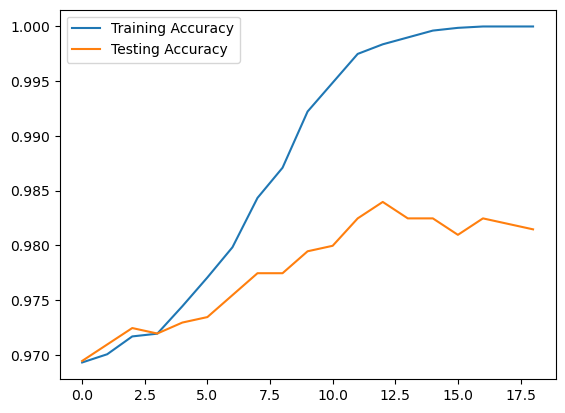

In [46]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Testing Accuracy")
plt.legend()
plt.show()

Max Depth = 3 is good, above that is overfitting

In [20]:
rf = RandomForestClassifier(
            n_estimators=100,
            n_jobs=-1,
            min_samples_leaf = 1,
            oob_score=True,
            max_depth=3,
            random_state = 42)
rf.fit(X_train, y_train)
    
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.972
RF test accuracy: 0.973


<Axes: >

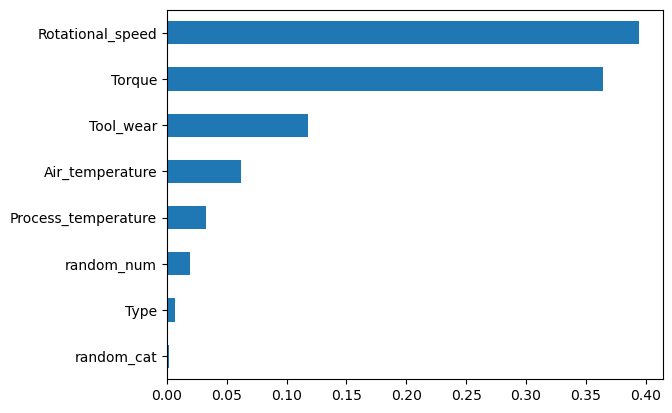

In [25]:
from matplotlib.pyplot import figure
feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')

Permutation Feature importance

In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
Rotational_speed,-0.000050,0.000150
Torque,0.000000,0.000000
Tool_wear,0.000100,0.000200
Type,0.000100,0.000301
Air_temperature,0.003507,0.000000
Process_temperature,0.003607,0.000301


In [62]:
# from sklearn.inspection import permutation_importance
# #calculate permutation importance for test data 
# result_test = permutation_importance(
#     rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
# )

# sorted_importances_idx_test = result_test.importances_mean.argsort()
# importances_test = pd.DataFrame(
#     result_test.importances[sorted_importances_idx_test].T,
#     columns=X.columns[sorted_importances_idx_test],
# )

# #calculate permutation importance for training data 
# result_train = permutation_importance(
#     rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
# )

# sorted_importances_idx_train = result_train.importances_mean.argsort()
# importances_train = pd.DataFrame(
#     result_train.importances[sorted_importances_idx_train].T,
#     columns=X.columns[sorted_importances_idx_train],
# )

# f, axs = plt.subplots(1,2,figsize=(15,5))

# importances_test.plot.box(vert=False, whis=10, ax = axs[0])
# axs[0].set_title("Permutation Importances (test set)")
# axs[0].axvline(x=0, color="k", linestyle="--")
# axs[0].set_xlabel("Decrease in accuracy score")
# axs[0].figure.tight_layout()

# importances_train.plot.box(vert=False, whis=10, ax = axs[1])
# axs[1].set_title("Permutation Importances (train set)")
# axs[1].axvline(x=0, color="k", linestyle="--")
# axs[1].set_xlabel("Decrease in accuracy score")
# axs[1].figure.tight_layout()

In [22]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(rf, X_train)


In [23]:
np.mean(contributions, axis=0)

array([[-5.88788538e-06,  5.57973427e-06, -2.52476014e-07,
         2.20554114e-06, -1.64491402e-06],
       [-1.18876831e-05,  1.07416151e-05, -9.32816540e-07,
         2.27701683e-06, -1.98132226e-07],
       [-1.20654605e-05,  7.53571139e-05,  7.34536178e-06,
        -6.90210089e-05, -1.61600623e-06],
       [-4.39007620e-06,  2.02844014e-04, -8.72491081e-05,
        -1.17487226e-04,  6.28239669e-06],
       [ 3.95283929e-06,  7.32871972e-05, -6.39425305e-05,
         2.98517504e-06, -1.62826811e-05],
       [ 2.86732026e-07, -1.36868619e-06, -3.47393608e-07,
        -1.73512163e-07,  1.60285994e-06]])

In [24]:
pd.Series(np.mean(contributions, axis=0), index=X_train.columns).sort_values(ascending=True).plot.barh(color='green')

ValueError: Data must be 1-dimensional, got ndarray of shape (6, 5) instead

<Axes: ylabel='Feature'>

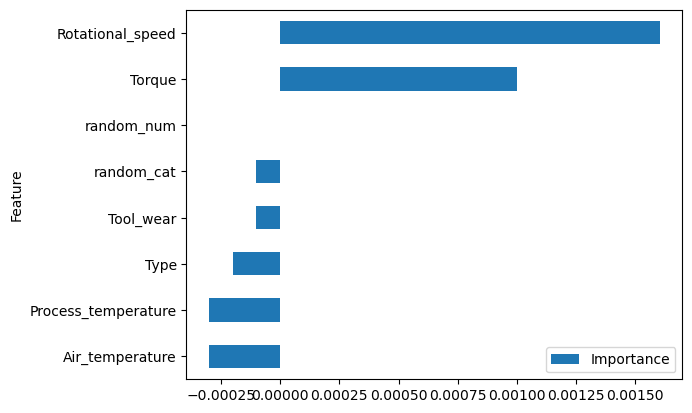

In [33]:
from sklearn.base import clone
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


imp = dropcol_importances(rf, X, y)
imp.plot(kind = 'barh')

In [50]:
X = df[NUMERIC_FEATURES]
y = df['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [51]:
new_train_accuracies = []
new_test_accuracies = []

for md in range(1,20):
    rf = RandomForestClassifier(
            n_estimators=100,
            n_jobs=-1,
            min_samples_leaf = 1,
            oob_score=True,
            max_depth=md,
            random_state = 42)
    rf.fit(X_train, y_train)
#     print("Max Depth:", md)
    
    new_train_accuracies.append(rf.score(X_train, y_train))
    new_test_accuracies.append(rf.score(X_test, y_test))
#     print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
#     print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

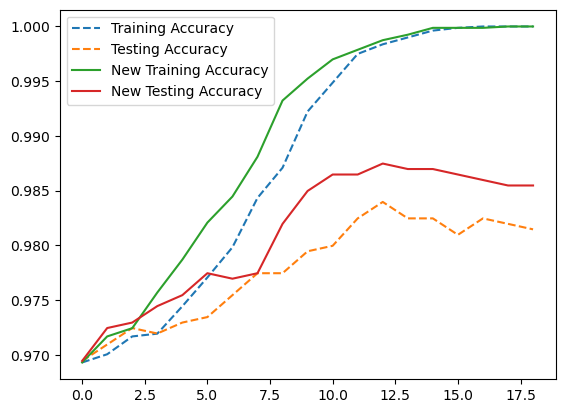

In [55]:
plt.plot(train_accuracies, label="Training Accuracy", linestyle='dashed')
plt.plot(test_accuracies, label="Testing Accuracy", linestyle='dashed')
plt.plot(new_train_accuracies, label="New Training Accuracy")
plt.plot(new_test_accuracies, label="New Testing Accuracy")
plt.legend()
plt.show()